### C) Stack two layers of LSTM, the output of stacked LSTM goes to Global maxpool 1d, followed by FC with 16 neurons with ReLU, followed by FC layer with single output with sigmoid  function. 

In [44]:
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of encodings to try
encodings_to_try = ['utf-8', 'latin1', 'iso-8859-1']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv("IMDB_Dataset.csv", encoding=encoding)
        break  # Break the loop if successful
    except UnicodeDecodeError:
        print("Failed to read with encoding '{}'".format(encoding))
        continue

# Display the first few rows of the DataFrame
df.head()

# Cleaning up the text
nltk.download("stopwords")
stopWords = set(nltk.corpus.stopwords.words("english"))

def CleanText(text):
    text = text.lower() 
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"] = df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:


# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Convert text data to sequences
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)
tokenizer.fit_on_texts(Data)
IntegerizedData = tokenizer.texts_to_sequences(Data)

# Zero padding
maxlen = 256
IntegerizedData = pad_sequences(IntegerizedData, maxlen=maxlen)



In [15]:
# Train-validation-test split
x_train_val, x_test, y_train_val, y_test = train_test_split(IntegerizedData, labels, stratify=labels, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size=0.10, random_state=42)


# BEST TO SUBMIT

/tmp/ipykernel_164/1518059587.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_164/1518059587.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_164/1518059587.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_164/1518059587.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/55, Loss: 0.6944, Validation Loss: 0.6936, Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 2/55, Loss: 0.6932, Validation Loss: 0.6930, Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 3/55, Loss: 0.6926, Validation Loss: 0.6922, Train Accuracy: 0.5038, Validation Accuracy: 0.5088
Epoch 4/55, Loss: 0.6909, Validation Loss: 0.6886, Train Accuracy: 0.5545, Validation Accuracy: 0.6230
Epoch 5/55, Loss: 0.6779, Validation Loss: 0.6596, Train Accuracy: 0.6397, Validation Accuracy: 0.6478
Epoch 6/55, Loss: 0.6262, Validation Loss: 0.6076, Train Accuracy: 0.6639, Validation Accuracy: 0.6700
Epoch 7/55, Loss: 0.5914, Validation Loss: 0.5889, Train Accuracy: 0.6876, Validation Accuracy: 0.6800
Epoch 8/55, Loss: 0.5734, Validation Loss: 0.5757, Train Accuracy: 0.7016, Validation Accuracy: 0.6963
Epoch 9/55, Loss: 0.5563, Validation Loss: 0.5602, Train Accuracy: 0.7152, Validation Accuracy: 0.7097
Epoch 10/55, Loss: 0.5370, Validation Loss: 0.5389, Train Accuracy: 0.730

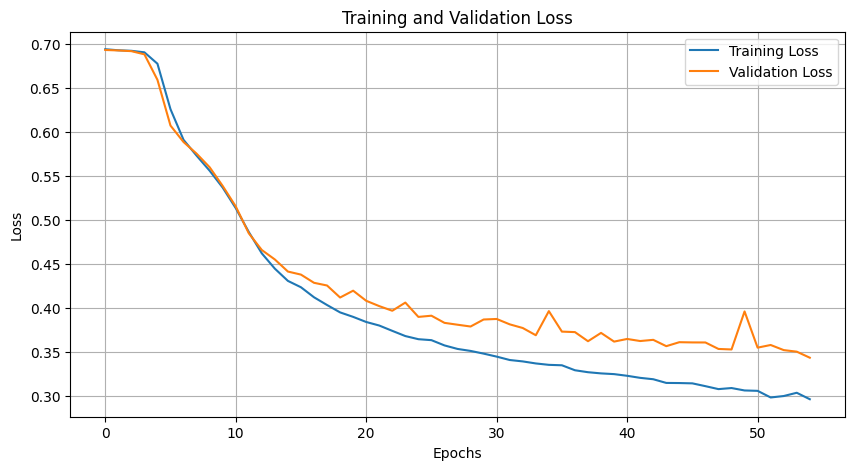

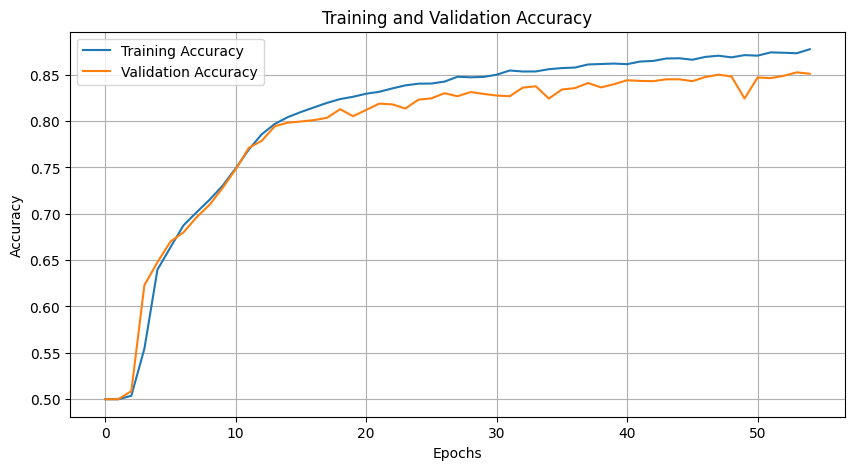

In [67]:


# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the model with possible dropout adjustment
class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)
        pooled_out = self.pool(lstm_out).squeeze(-1)
        fc1_out = self.fc1(pooled_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0
batch_size = 128
num_epochs = 55
learning_rate = 7e-5
weight_decay = 8e-4

# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Training Loss: 0.2964, Validation Loss: 0.3436
#### Train Accuracy: 0.8774, Validation Accuracy: 0.8510, Test Accuracy: 0.8510
#### Compute Time: 75 seconds

# PREVIOUS ATTEMPTS

/tmp/ipykernel_3337/2858820630.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_3337/2858820630.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_3337/2858820630.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_3337/2858820630.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/85, Loss: 0.6931, Validation Loss: 0.6931, Train Accuracy: 0.5034, Validation Accuracy: 0.4998
Epoch 2/85, Loss: 0.6929, Validation Loss: 0.6930, Train Accuracy: 0.5203, Validation Accuracy: 0.4998
Epoch 3/85, Loss: 0.6928, Validation Loss: 0.6929, Train Accuracy: 0.5139, Validation Accuracy: 0.5000
Epoch 4/85, Loss: 0.6927, Validation Loss: 0.6927, Train Accuracy: 0.5194, Validation Accuracy: 0.4998
Epoch 5/85, Loss: 0.6923, Validation Loss: 0.6922, Train Accuracy: 0.5310, Validation Accuracy: 0.5135
Epoch 6/85, Loss: 0.6918, Validation Loss: 0.6917, Train Accuracy: 0.5513, Validation Accuracy: 0.5108
Epoch 7/85, Loss: 0.6908, Validation Loss: 0.6904, Train Accuracy: 0.5848, Validation Accuracy: 0.5202
Epoch 8/85, Loss: 0.6881, Validation Loss: 0.6865, Train Accuracy: 0.6151, Validation Accuracy: 0.5850
Epoch 9/85, Loss: 0.6804, Validation Loss: 0.6735, Train Accuracy: 0.6262, Validation Accuracy: 0.6298
Epoch 10/85, Loss: 0.6525, Validation Loss: 0.6371, Train Accuracy: 0.650

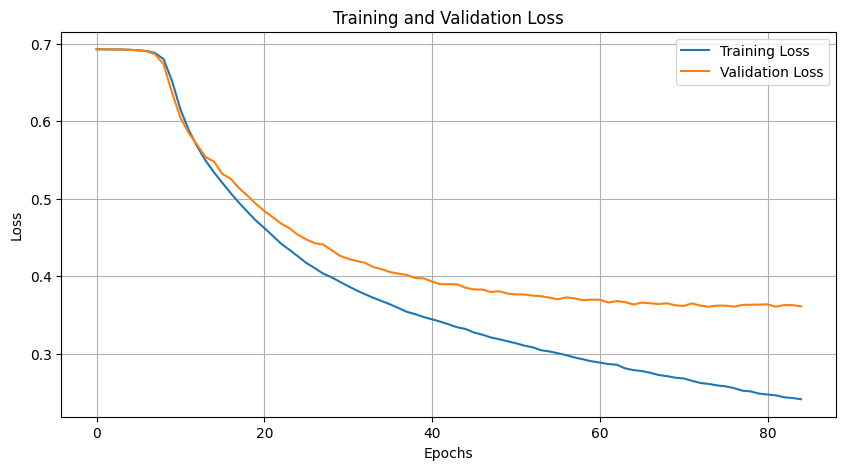

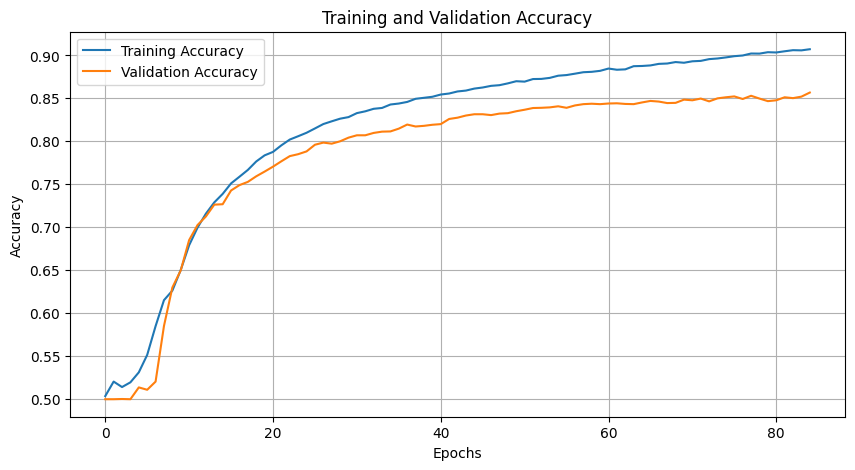

In [27]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the model with possible dropout adjustment
class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)
        pooled_out = self.pool(lstm_out).squeeze(-1)
        fc1_out = self.fc1(pooled_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.5
batch_size = 512
num_epochs = 85
learning_rate = 0.00005
weight_decay = 3e-7

# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3337/3979897646.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_3337/3979897646.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_3337/3979897646.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_3337/3979897646.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/85, Loss: 0.6933, Validation Loss: 0.6933, Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 2/85, Loss: 0.6932, Validation Loss: 0.6932, Train Accuracy: 0.4983, Validation Accuracy: 0.5000
Epoch 3/85, Loss: 0.6931, Validation Loss: 0.6931, Train Accuracy: 0.5072, Validation Accuracy: 0.5000
Epoch 4/85, Loss: 0.6930, Validation Loss: 0.6929, Train Accuracy: 0.5128, Validation Accuracy: 0.5000
Epoch 5/85, Loss: 0.6928, Validation Loss: 0.6927, Train Accuracy: 0.5232, Validation Accuracy: 0.5002
Epoch 6/85, Loss: 0.6925, Validation Loss: 0.6923, Train Accuracy: 0.5369, Validation Accuracy: 0.5070
Epoch 7/85, Loss: 0.6921, Validation Loss: 0.6916, Train Accuracy: 0.5804, Validation Accuracy: 0.5280
Epoch 8/85, Loss: 0.6911, Validation Loss: 0.6901, Train Accuracy: 0.6231, Validation Accuracy: 0.6078
Epoch 9/85, Loss: 0.6886, Validation Loss: 0.6862, Train Accuracy: 0.6332, Validation Accuracy: 0.6545
Epoch 10/85, Loss: 0.6812, Validation Loss: 0.6727, Train Accuracy: 0.647

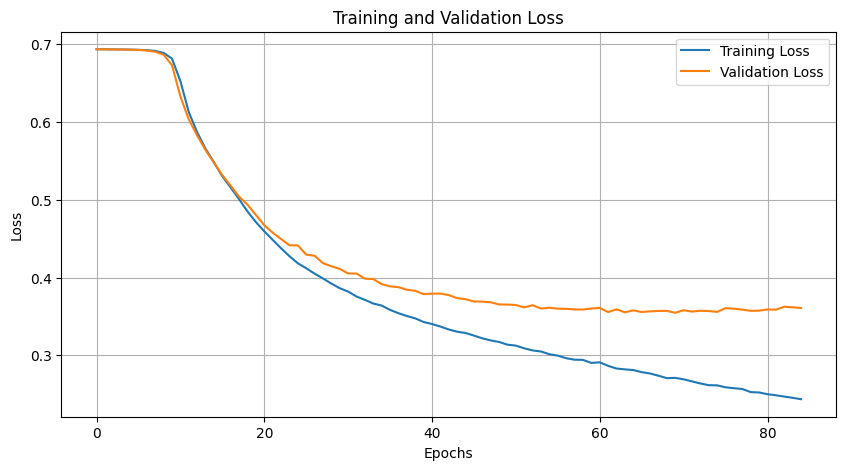

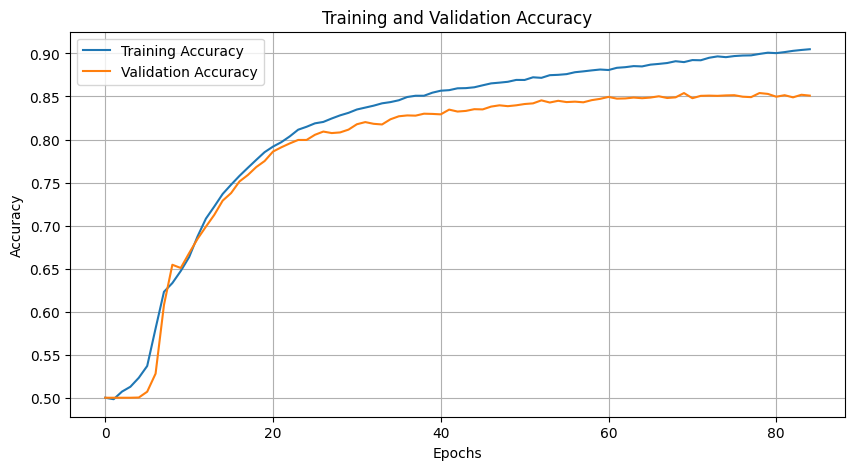

In [28]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the model with possible dropout adjustment
class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)
        pooled_out = self.pool(lstm_out).squeeze(-1)
        fc1_out = self.fc1(pooled_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.5
batch_size = 512
num_epochs = 85
learning_rate = 0.00005
weight_decay = 1e-5

# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/85, Loss: 0.6984, Validation Loss: 0.6982, Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 2/85, Loss: 0.6942, Validation Loss: 0.6953, Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 3/85, Loss: 0.6930, Validation Loss: 0.6940, Train Accuracy: 0.5001, Validation Accuracy: 0.5000
Epoch 4/85, Loss: 0.6928, Validation Loss: 0.6941, Train Accuracy: 0.5068, Validation Accuracy: 0.5000
Epoch 5/85, Loss: 0.6928, Validation Loss: 0.6941, Train Accuracy: 0.5059, Validation Accuracy: 0.5000
Epoch 6/85, Loss: 0.6928, Validation Loss: 0.6939, Train Accuracy: 0.5070, Validation Accuracy: 0.5000
Epoch 7/85, Loss: 0.6928, Validation Loss: 0.6938, Train Accuracy: 0.5087, Validation Accuracy: 0.5000
Epoch 8/85, Loss: 0.6927, Validation Loss: 0.6938, Train Accuracy: 0.5098, Validation Accuracy: 0.5000
Epoch 9/85, Loss: 0.6927, Validation Loss: 0.6937, Train Accuracy: 0.5099, Validation Accuracy: 0.5000
Epoch 10/85, Loss: 0.6926, Validation Loss: 0.6936, Train Accuracy: 0.514

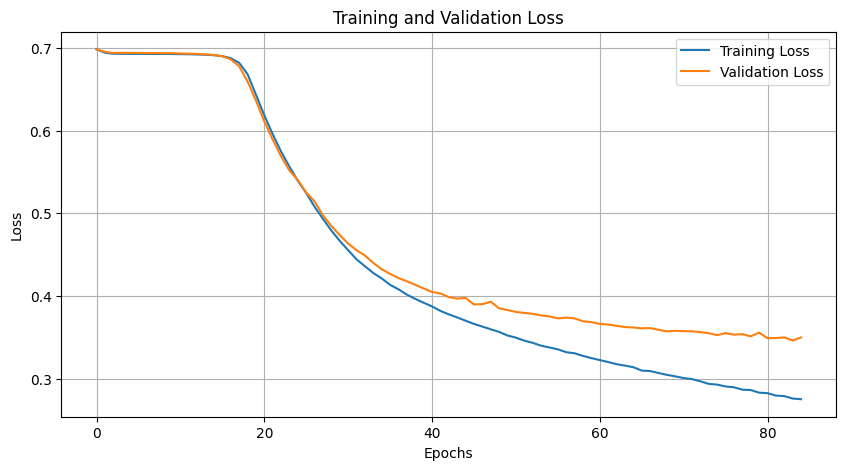

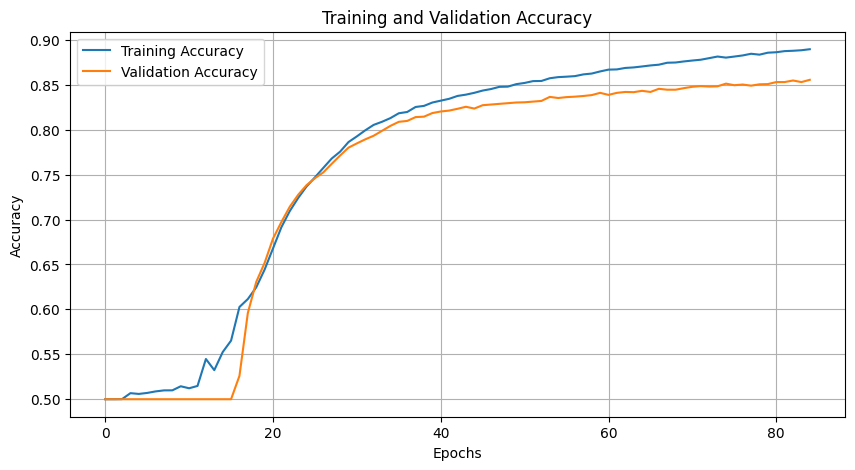

In [6]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the model with possible dropout adjustment
class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)
        pooled_out = self.pool(lstm_out).squeeze(-1)
        fc1_out = self.fc1(pooled_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.5
batch_size = 700
num_epochs = 85
learning_rate = 0.00005
weight_decay = 1e-5

# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_164/3078065947.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_164/3078065947.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_164/3078065947.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_164/3078065947.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/100, Loss: 0.6943, Validation Loss: 0.6941, Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 2/100, Loss: 0.6935, Validation Loss: 0.6937, Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 3/100, Loss: 0.6934, Validation Loss: 0.6936, Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 4/100, Loss: 0.6932, Validation Loss: 0.6933, Train Accuracy: 0.5018, Validation Accuracy: 0.5000
Epoch 5/100, Loss: 0.6928, Validation Loss: 0.6926, Train Accuracy: 0.5029, Validation Accuracy: 0.5000
Epoch 6/100, Loss: 0.6918, Validation Loss: 0.6909, Train Accuracy: 0.5467, Validation Accuracy: 0.5000
Epoch 7/100, Loss: 0.6888, Validation Loss: 0.6854, Train Accuracy: 0.5552, Validation Accuracy: 0.5000
Epoch 8/100, Loss: 0.6768, Validation Loss: 0.6632, Train Accuracy: 0.6137, Validation Accuracy: 0.6268
Epoch 9/100, Loss: 0.6493, Validation Loss: 0.6408, Train Accuracy: 0.6401, Validation Accuracy: 0.6492
Epoch 10/100, Loss: 0.6332, Validation Loss: 0.6286, Train Accur

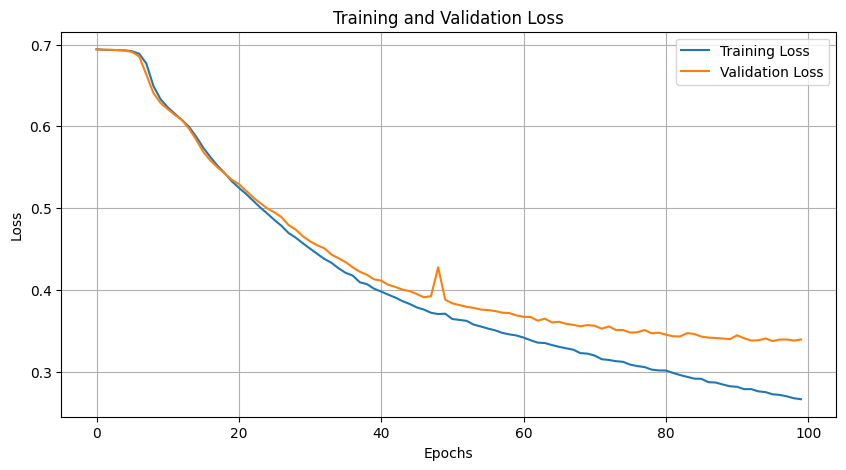

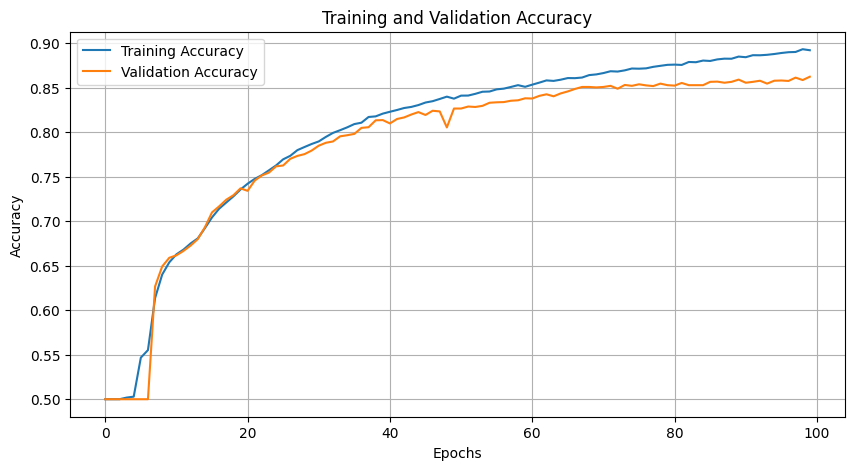

In [20]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the model with possible dropout adjustment
class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)
        pooled_out = self.pool(lstm_out).squeeze(-1)
        fc1_out = self.fc1(pooled_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.5
batch_size = 160
num_epochs = 100
learning_rate = 0.00003
weight_decay = 5e-5

# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_164/2162540746.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_164/2162540746.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_164/2162540746.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_164/2162540746.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/100, Loss: 0.6935, Validation Loss: 0.6935, Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 2/100, Loss: 0.6929, Validation Loss: 0.6931, Train Accuracy: 0.5082, Validation Accuracy: 0.5000
Epoch 3/100, Loss: 0.6927, Validation Loss: 0.6930, Train Accuracy: 0.5138, Validation Accuracy: 0.5000
Epoch 4/100, Loss: 0.6926, Validation Loss: 0.6926, Train Accuracy: 0.5412, Validation Accuracy: 0.5000
Epoch 5/100, Loss: 0.6922, Validation Loss: 0.6921, Train Accuracy: 0.5326, Validation Accuracy: 0.5025
Epoch 6/100, Loss: 0.6914, Validation Loss: 0.6910, Train Accuracy: 0.5412, Validation Accuracy: 0.5343
Epoch 7/100, Loss: 0.6900, Validation Loss: 0.6888, Train Accuracy: 0.5591, Validation Accuracy: 0.5897
Epoch 8/100, Loss: 0.6868, Validation Loss: 0.6845, Train Accuracy: 0.6118, Validation Accuracy: 0.6225
Epoch 9/100, Loss: 0.6805, Validation Loss: 0.6753, Train Accuracy: 0.6228, Validation Accuracy: 0.6368
Epoch 10/100, Loss: 0.6665, Validation Loss: 0.6570, Train Accur

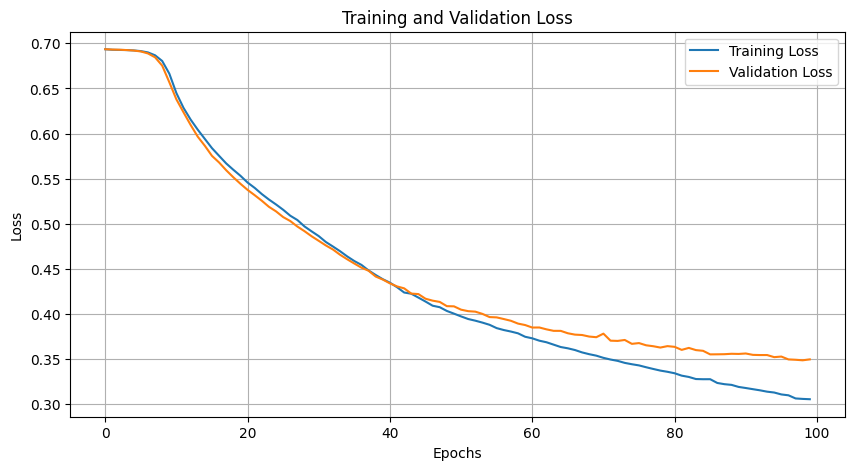

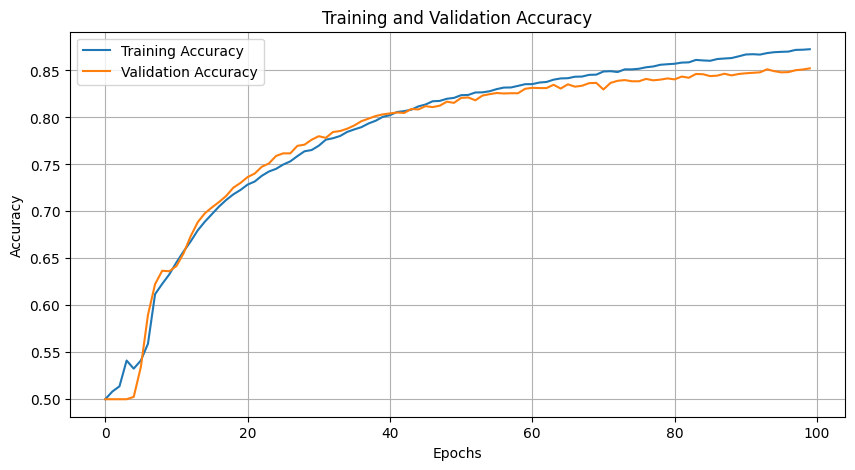

In [27]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the model with possible dropout adjustment
class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)
        pooled_out = self.pool(lstm_out).squeeze(-1)
        fc1_out = self.fc1(pooled_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.5
batch_size = 140
num_epochs = 100
learning_rate = 0.00002
weight_decay = 6e-5

# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_164/2382620395.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_164/2382620395.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_164/2382620395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_164/2382620395.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/100, Loss: 0.6933, Validation Loss: 0.6930, Train Accuracy: 0.5019, Validation Accuracy: 0.5000
Epoch 2/100, Loss: 0.6929, Validation Loss: 0.6928, Train Accuracy: 0.5145, Validation Accuracy: 0.4998
Epoch 3/100, Loss: 0.6927, Validation Loss: 0.6925, Train Accuracy: 0.5268, Validation Accuracy: 0.5288
Epoch 4/100, Loss: 0.6925, Validation Loss: 0.6922, Train Accuracy: 0.5343, Validation Accuracy: 0.5615
Epoch 5/100, Loss: 0.6921, Validation Loss: 0.6916, Train Accuracy: 0.5416, Validation Accuracy: 0.5583
Epoch 6/100, Loss: 0.6912, Validation Loss: 0.6902, Train Accuracy: 0.5716, Validation Accuracy: 0.6182
Epoch 7/100, Loss: 0.6888, Validation Loss: 0.6865, Train Accuracy: 0.5982, Validation Accuracy: 0.6265
Epoch 8/100, Loss: 0.6821, Validation Loss: 0.6742, Train Accuracy: 0.6313, Validation Accuracy: 0.6440
Epoch 9/100, Loss: 0.6565, Validation Loss: 0.6302, Train Accuracy: 0.6483, Validation Accuracy: 0.6693
Epoch 10/100, Loss: 0.6155, Validation Loss: 0.5959, Train Accur

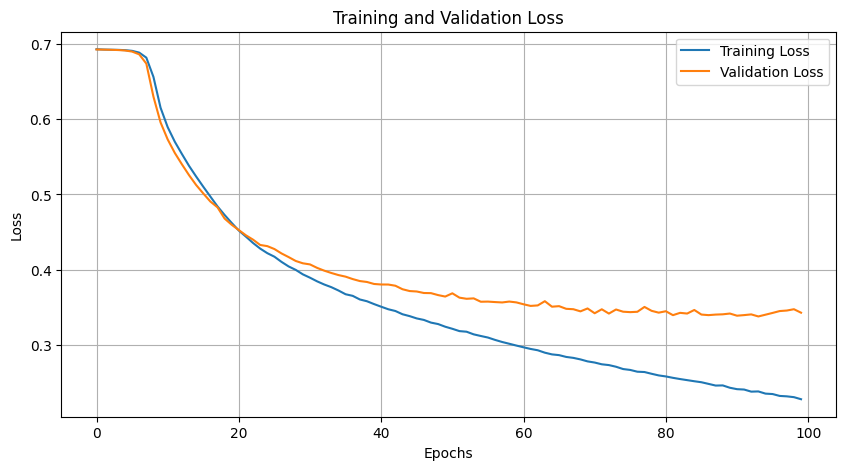

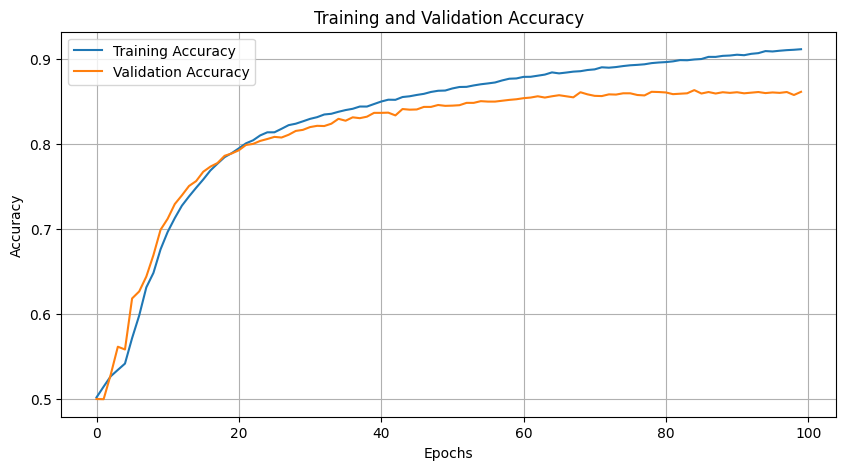

In [31]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the model with possible dropout adjustment
class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)
        pooled_out = self.pool(lstm_out).squeeze(-1)
        fc1_out = self.fc1(pooled_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.5
batch_size = 140
num_epochs = 100
learning_rate = 0.00003
weight_decay = 5e-5

# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_164/3916452637.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_164/3916452637.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_164/3916452637.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_164/3916452637.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/100, Loss: 0.6943, Validation Loss: 0.6933, Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 2/100, Loss: 0.6930, Validation Loss: 0.6930, Train Accuracy: 0.5022, Validation Accuracy: 0.5000
Epoch 3/100, Loss: 0.6928, Validation Loss: 0.6928, Train Accuracy: 0.5129, Validation Accuracy: 0.5000
Epoch 4/100, Loss: 0.6927, Validation Loss: 0.6928, Train Accuracy: 0.5255, Validation Accuracy: 0.5000
Epoch 5/100, Loss: 0.6926, Validation Loss: 0.6926, Train Accuracy: 0.5302, Validation Accuracy: 0.5000
Epoch 6/100, Loss: 0.6923, Validation Loss: 0.6925, Train Accuracy: 0.5251, Validation Accuracy: 0.5000
Epoch 7/100, Loss: 0.6919, Validation Loss: 0.6911, Train Accuracy: 0.5467, Validation Accuracy: 0.5282
Epoch 8/100, Loss: 0.6887, Validation Loss: 0.6846, Train Accuracy: 0.6129, Validation Accuracy: 0.6005
Epoch 9/100, Loss: 0.6673, Validation Loss: 0.6394, Train Accuracy: 0.6361, Validation Accuracy: 0.6502
Epoch 10/100, Loss: 0.6157, Validation Loss: 0.5959, Train Accur

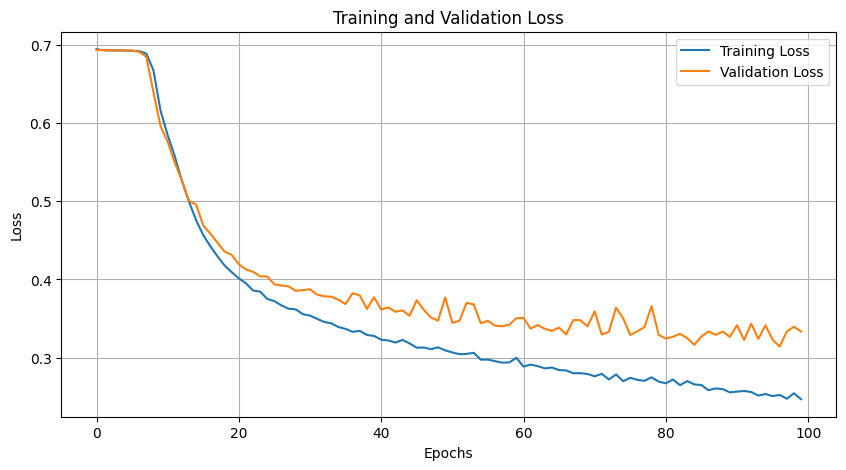

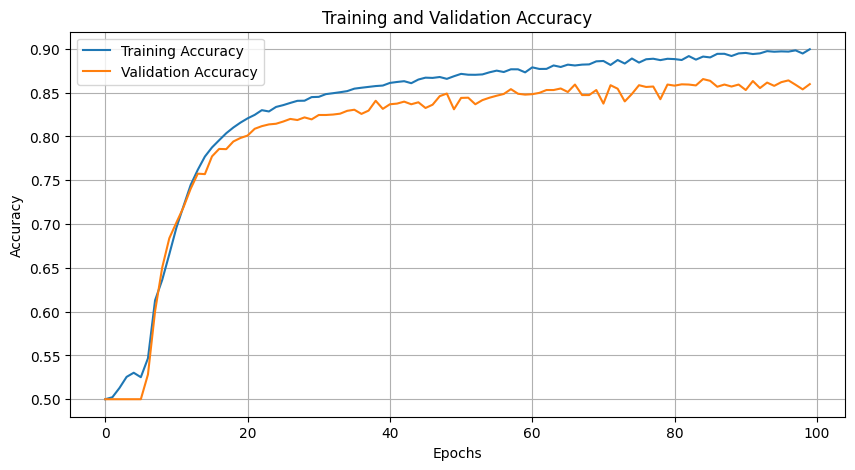

In [64]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the model with possible dropout adjustment
class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)
        pooled_out = self.pool(lstm_out).squeeze(-1)
        fc1_out = self.fc1(pooled_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.43
batch_size = 256
num_epochs = 100
learning_rate = 0.0001
weight_decay = 7e-4

# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()